In [1]:
from datetime import datetime, timedelta
import pytz
import math
import pylab as plt

import pandas as pd
import numpy as np

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

%load_ext autoreload

%matplotlib widget
from plotter import Plot
from filewriter import ExcelWriter as ex

from extractor import WeatherExtractor, Extractor, Period

from inversegreyboxmodel import Learner

import logging
logger = logging.getLogger('Twomes data extraction')
logger.setLevel(logging.NOTSET)



n_std_outliers = 3.0 # default for the multiplier of the the standard deviation; further out than this times the std, outliers are removed during preprocessing
up_intv = '5min' # the default upsampling interval that is used before interpolation is done
gap_n_intv = 11 # the default maximum number of consecutive NaNs to fill(one for each upsampling interval), i.e. valid measurement values (11+1)* 5 min = 1 hour apart apart will be bridget by interpolation, but not more
sampling_interval = '15min' # the default interval on which interpolation will be done during preprocessing
moving_horizon_duration_d = 7
required_columns_for_sanity = ['home_id', 'T_out_e_avg_C', 'irradiation_hor_avg_W_p_m2', 'T_in_avg_C', 'gas_sup_avg_W', 'e_remaining_heat_avg_W', 'interval_s']
        

sanity_fraction = 0.5

#location: center of Assendorp neighbourhood in Zwolle
lat, lon = 52.50655, 6.09961

#timezone: 
timezone_database = 'UTC'
timezone_homes = 'Europe/Amsterdam'

# TODO: get list of pseudonyms, (valid) dates and reference parameters from Excel file?  
# utimately: #min, max dates of the analysis

# # Below, the maximum period for data collection
# first_day = pytz.timezone(timezone_homes).localize(datetime(2021, 10, 25))
# last_day = pytz.timezone(timezone_homes).localize(datetime(2022, 5, 8))

# However, as long as this issue https://github.com/stephanpcpeters/HourlyHistoricWeather/issues/4 is not fixed, restrict yourself to a period without a DST change. NB The last week is not a full week!
first_day = pytz.timezone(timezone_homes).localize(datetime(2021, 11, 1))
last_day = pytz.timezone(timezone_homes).localize(datetime(2022, 3, 26))

# # Alternatively, you may want to test things only on a three week periode. This is a period with suitable weather and lots of homes with measurements.
# first_day = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 3))
# last_day = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 24))

# The full set of homes
homes = [803422, 805164, 809743, 811308, 815925, 817341, 822479, 829947, 830088, 831062, 839440, 845966, 845997, 846697, 857477, 864296, 873985, 879481, 881611, 886307, 895671, 897349, 899510]

# # A subset of homes
# homes = [803422, 805164, 809743]


100% 3504/3504 [00:58<00:00, 59.93it/s]


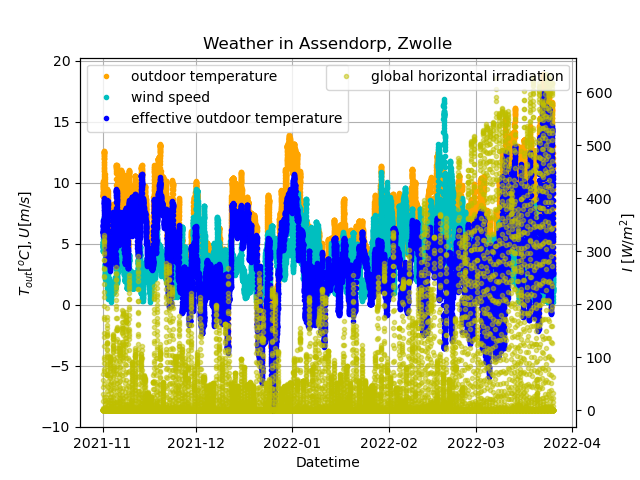

CPU times: user 1min 3s, sys: 1.29 s, total: 1min 4s
Wall time: 1min 6s


In [2]:
%%time 
%autoreload 2
# get geospatially interpolated weather from KNMI
# for Twomes, the Weather for all all homes studies can be approached by a single location
# get the dataframe only once for all homes to save time
tz_knmi='Europe/Amsterdam'

df_weather = WeatherExtractor.get_interpolated_weather_nl(first_day, last_day, lat, lon, tz_knmi, timezone_homes, sampling_interval)

# plot temperature data
logger.setLevel(logging.NOTSET)
Plot.weather_and_other_temperatures('Weather in Assendorp, Zwolle', df_weather)

# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [3]:
#see more statisctics about the weather data
df_weather.describe(include='all')

,T_out_avg_C,wind_avg_m_p_s,irradiation_hor_avg_W_p_m2,T_out_e_avg_C
count,13921.000000,13921.000000,13921.000000,13921.000000
mean,5.901674,3.726698,52.808832,3.417209
std,3.802281,2.203945,113.671229,3.594732
min,-5.675577,0.085329,0.000000,-8.649752
25%,3.617940,2.170658,0.000000,1.174083
50%,5.881491,3.324568,0.000000,3.451494
75%,8.488781,4.914671,45.940011,5.760489
max,18.873668,16.822007,633.215872,17.310345


In [4]:
%%time 
# get interpolated data from the Twomes database and combine with weather data already obtained

logger.setLevel(logging.INFO)

df_data_homes = Extractor.get_preprocessed_homes_data(homes, first_day, last_day, timezone_database, timezone_homes,
                                                      up_intv, gap_n_intv, sampling_interval, 
                                                      required_columns_for_sanity,
                                                      df_weather)
filename_prefix = datetime.now().astimezone(pytz.timezone('Europe/Amsterdam')).replace(microsecond=0).isoformat().replace(":","")
ex.write(df_data_homes, str('{0}-data_homes-{1}-{2}.xlsx'.format(filename_prefix, first_day.isoformat(),last_day.isoformat())))

logger.setLevel(logging.NOTSET)


  0%|          | 0/23 [00:00<?, ?it/s]

CPU times: user 5min 46s, sys: 7.18 s, total: 5min 53s
Wall time: 36min 43s


In [ ]:
%%time 
# # get interpolated data from the virtual homes and combine with weather data already obtained

# logger.setLevel(logging.INFO)

# homes = [
#     60200, 
#     120100, 
#     150080, 
#     150100, 
#     200060, 
#     300040, 
#     400030, 
#     600020 
# ]

# first_day = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 3))
# last_day = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 24))

# df_data_homes = pd.DataFrame()
# for home_id in homes:
#     df_data_homes = pd.concat([df_data_homes, Extractor.get_virtual_home_data_csv(str('../data/virtualhome_P{0}.csv'.format(home_id)), timezone_homes)], axis=0)

# logger.setLevel(logging.NOTSET)


In [5]:
df_data_homes

T_out_avg_C  wind_avg_m_p_s  \
home_id  timestamp                                                
803422.0 2021-11-01 00:00:00+01:00    10.151564        4.775296   
         2021-11-01 00:15:00+01:00    10.082182        4.840210   
         2021-11-01 00:30:00+01:00    10.012799        4.905124   
         2021-11-01 00:45:00+01:00     9.943417        4.970037   
         2021-11-01 01:00:00+01:00     9.874035        5.034951   
...                                         ...             ...   
NaN      2022-03-26 22:45:00+01:00          NaN             NaN   
         2022-03-26 23:00:00+01:00          NaN             NaN   
         2022-03-26 23:15:00+01:00          NaN             NaN   
         2022-03-26 23:30:00+01:00          NaN             NaN   
         2022-03-26 23:45:00+01:00          NaN             NaN   

                                    irradiation_hor_avg_W_p_m2  T_out_e_avg_C  \
home_id  timestamp                                                              
803422.0 2021-11-01 00:00:00+01:00                         0.0       6.968033   
         2021-11-01 00:15:00+01:00                         0.0       6.855375   
         2021-11-01 00:30:00+01:00                         0.0       6.742717   
         2021-11-01 00:45:00+01:00                         0.0       6.630059   
         2021-11-01 01:00:00+01:00                         0.0       6.517401   
...                                                        ...            ...   
NaN      2022-03-26 22:45:00+01:00                         NaN            NaN   
         2022-03-26 23:00:00+01:00                         NaN            NaN   
         2022-03-26 23:15:00+01:00                         NaN            NaN   
         2022-03-26 23:30:00+01:00                         NaN            NaN   
         2022-03-26 23:45:00+01:00                         NaN            NaN   

                                    T_in_avg_C  T_set_first_C  interval_s  \
home_id  timestamp                                                          
803422.0 2021-11-01 00:00:00+01:00         NaN            NaN       900.0   
         2021-11-01 00:15:00+01:00         NaN            NaN       900.0   
         2021-11-01 00:30:00+01:00         NaN            NaN       900.0   
         2021-11-01 00:45:00+01:00         NaN            NaN       900.0   
         2021-11-01 01:00:00+01:00         NaN            NaN       900.0   
...                                        ...            ...         ...   
NaN      2022-03-26 22:45:00+01:00       20.72           20.0       900.0   
         2022-03-26 23:00:00+01:00       20.72           17.0       900.0   
         2022-03-26 23:15:00+01:00       20.72           17.0       900.0   
         2022-03-26 23:30:00+01:00       20.72           17.0       900.0   
         2022-03-26 23:45:00+01:00       20.72           17.0       900.0   

                                    gas_sup_avg_W  e_used_avg_W  \
home_id  timestamp                                                
803422.0 2021-11-01 00:00:00+01:00            NaN           NaN   
         2021-11-01 00:15:00+01:00            NaN           NaN   
         2021-11-01 00:30:00+01:00            NaN           NaN   
         2021-11-01 00:45:00+01:00            NaN           NaN   
         2021-11-01 01:00:00+01:00            NaN           NaN   
...                                           ...           ...   
NaN      2022-03-26 22:45:00+01:00       0.000000         424.0   
         2022-03-26 23:00:00+01:00       0.000000         348.0   
         2022-03-26 23:15:00+01:00       0.000000         352.0   
         2022-03-26 23:30:00+01:00      39.077778         436.0   
         2022-03-26 23:45:00+01:00       0.000000         352.0   

                                    e_returned_avg_W  e_remaining_heat_avg_W  \
home_id  timestamp                                                             
803422.0 2021-11-01 00:00:00+01:00               NaN                     NaN

In [6]:
# present some sanity metrics for the extracted data
total_measurement_time = timedelta(seconds = df_data_homes['interval_s'].sum())
print('Total measurement time: ', total_measurement_time)
sane_fraction = df_data_homes['sanity_frac'].mean()
print('Sane fraction measurement time: {:.2f}'.format(sane_fraction))
sane_measurement_time = total_measurement_time * sane_fraction
print('Sane  measurement time: ', sane_measurement_time)

#see more statisctics
df_data_homes.describe(include='all')

Total measurement time:  3340 days, 0:00:00
Sane fraction measurement time: 0.46
Sane  measurement time:  1540 days, 0:40:30.402485


,T_out_avg_C,wind_avg_m_p_s,irradiation_hor_avg_W_p_m2,T_out_e_avg_C,T_in_avg_C,T_set_first_C,interval_s,gas_sup_avg_W,e_used_avg_W,e_returned_avg_W,e_remaining_heat_avg_W,sanity_frac
count,320183.000000,320183.000000,320183.000000,320183.000000,150827.000000,80536.000000,320640.0,177125.000000,177175.000000,177175.000000,177175.000000,320658.000000
mean,5.901674,3.726698,52.808832,3.417209,18.612041,13.016608,900.0,1776.480733,263.589431,65.267515,198.321917,0.461086
std,3.802150,2.203869,113.667324,3.594609,1.597905,7.396219,0.0,2719.411548,402.022983,283.142213,522.177082,0.498484
min,-5.675577,0.085329,0.000000,-8.649752,11.938529,0.000000,900.0,0.000000,0.000000,0.000000,-4056.000000,0.000000
25%,3.617940,2.170658,0.000000,1.174083,17.576176,5.080000,900.0,0.000000,64.000000,0.000000,60.000000,0.000000
50%,5.881491,3.324568,0.000000,3.451494,18.753333,17.000000,900.0,185.619444,132.000000,0.000000,132.000000,0.000000
75%,8.488781,4.914671,45.940011,5.760489,19.960000,18.500000,900.0,2774.522222,284.000000,0.000000,280.000000,1.000000
max,18.873668,16.822007,633.215872,17.310345,28.650000,44.000000,900.0,24306.377778,5692.000000,4088.000000,5692.000000,1.000000


In [7]:
%%time 
%autoreload 2


sanity_fraction_analysis = sanity_fraction

# Use one of the lines below to set the moving horizon duration used for analysis 
# moving_horizon_duration_d_analysis = 14
moving_horizon_duration_d_analysis = moving_horizon_duration_d


# learn the model parameters and write rerults an intermediate results to excel files
df_results = Learner.learn_home_parameter_moving_horizon(df_data_homes, 
                                                         n_std_outliers, up_intv, gap_n_intv, sampling_interval, 
                                                         moving_horizon_duration_d_analysis, sanity_fraction_analysis,
                                                         homes, first_day, last_day, 
                                                         hint_A_m2=12.0, ev_type=2)



Homes to analyse:  [803422, 805164, 809743, 811308, 815925, 817341, 822479, 829947, 830088, 831062, 839440, 845966, 845997, 846697, 857477, 864296, 873985, 879481, 881611, 886307, 895671, 897349, 899510]
Start of analyses:  2021-11-01 00:00:00+01:00
End of analyses:  2022-03-26 00:00:00+01:00
Moving horizon:  7D
#standard deviations for outlier removal:  3.0
Upsampling_interval:  5min
#upsampling intervals bridged during interpolation (max):  11
Interpolation interval:  15min
Hint for effective window are A [m^2]:  12.0
Hint for superior heating efficiency eta [-]:  0.97
EV_TYPE:  2


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 803422 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 805164 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 805164 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 809743 in period from 2021-12-27 00:00:00+01:00 to 2022-01-02 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 809743 in period from 2021-12-27 00:00:00+01:00 to 2022-01-02 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 809743 in period from 2022-01-31 00:00:00+01:00 to 2022-02-06 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 809743 in period from 2022-01-31 00:00:00+01:00 to 2022-02-06 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 809743 in period from 2022-02-21 00:00:00+01:00 to 2022-02-27 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 809743 in period from 2022-03-07 00:00:00+01:00 to 2022-03-13 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 809743 in period from 2022-03-14 00:00:00+01:00 to 202

  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 811308 in period from 2021-12-20 00:00:00+01:00 to 2021-12-26 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 811308 in period from 2021-12-20 00:00:00+01:00 to 2021-12-26 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 811308 in period from 2022-02-21 00:00:00+01:00 to 2022-02-27 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 815925 in period from 2021-12-20 00:00:00+01:00 to 2021-12-26 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 815925 in period from 2021-12-20 00:00:00+01:00 to 2021-12-26 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 815925 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 815925 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 815925 in period from 2022-02-14 00:00:00+01:00 to 2022-02-20 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 817341 in period from 2022-03-07 00:00:00+01:00 to 2022-03-13 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 817341 in period from 2022-03-07 00:00:00+01:00 to 2022-03-13 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 822479 in period from 2021-12-13 00:00:00+01:00 to 2021-12-19 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 822479 in period from 2021-12-13 00:00:00+01:00 to 2021-12-19 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 829947 in period from 2022-03-14 00:00:00+01:00 to 2022-03-20 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 829947 in period from 2022-03-14 00:00:00+01:00 to 2022-03-20 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 830088 in period from 2022-01-31 00:00:00+01:00 to 2022-02-06 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 830088 in period from 2022-01-31 00:00:00+01:00 to 2022-02-06 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 830088 in period from 2022-02-21 00:00:00+01:00 to 2022-02-27 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 830088 in period from 2022-03-07 00:00:00+01:00 to 2022-03-13 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 831062 in period from 2022-03-14 00:00:00+01:00 to 2022-03-20 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 831062 in period from 2022-03-14 00:00:00+01:00 to 2022-03-20 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 839440 in period from 2021-12-20 00:00:00+01:00 to 2021-12-26 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 839440 in period from 2021-12-20 00:00:00+01:00 to 2021-12-26 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 845966 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 845966 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 845997 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 845997 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 845997 in period from 2022-02-28 00:00:00+01:00 to 2022-03-06 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 846697 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 846697 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 846697 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 846697 in period from 2022-03-07 00:00:00+01:00 to 2022-03-13 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 846697 in period from 2022-03-07 00:00:00+01:00 to 2022-03-13 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 857477 in period from 2021-12-20 00:00:00+01:00 to 2021-12-26 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 857477 in period from 2021-12-20 00:00:00+01:00 to 2021-12-26 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 857477 in period from 2022-01-03 00:00:00+01:00 to 2022-01-09 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 864296 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 864296 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 864296 in period from 2022-01-31 00:00:00+01:00 to 2022-02-06 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 864296 in period from 2022-02-07 00:00:00+01:00 to 2022-02-13 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 864296 in period from 2022-02-21 00:00:00+01:00 to 2022-02-27 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 864296 in period from 2022-02-21 00:00:00+01:00 to 2022-02-27 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 864296 in period from 2022-02-28 00:00:00+01:00 to 202

  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 873985 in period from 2021-12-13 00:00:00+01:00 to 2021-12-19 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 879481 in period from 2022-02-28 00:00:00+01:00 to 2022-03-06 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 879481 in period from 2022-03-14 00:00:00+01:00 to 2022-03-20 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 886307 in period from 2022-01-31 00:00:00+01:00 to 2022-02-06 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 895671 in period from 2021-12-13 00:00:00+01:00 to 2021-12-19 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 895671 in period from 2021-12-13 00:00:00+01:00 to 2021-12-19 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 895671 in period from 2021-12-27 00:00:00+01:00 to 2022-01-02 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 895671 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 895671 in period from 2022-01-31 00:00:00+01:00 to 2022-02-06 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 895671 in period from 2022-02-28 00:00:00+01:00 to 2022-03-06 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 897349 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 897349 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 897349 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 897349 in period from 2022-02-21 00:00:00+01:00 to 2022-02-27 23:45:00+01:00; skipping...


  0%|          | 0/21 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 899510 in period from 2022-02-28 00:00:00+01:00 to 2022-03-06 23:45:00+01:00; skipping...


DONE: Analysis of all homes complete; writing files.
          T_out_avg_C  wind_avg_m_p_s  irradiation_hor_avg_W_p_m2  \
count   280800.000000   280800.000000               280800.000000   
unique            NaN             NaN                         NaN   
top               NaN             NaN                         NaN   
freq              NaN             NaN                         NaN   
mean         5.646630        4.446115                   63.282600   
std          3.631981        2.471068                  125.227326   
min         -5.675577        0.085329                    0.000000   
25%          3.553883        2.604638                    0.000000   
50%          5.753107        4.170658                    0.000000   
75%          8.005658        5.775296                   55.448282   
max         18.873668       16.822007                  633.215872   

        T_out_e_avg_C     T_in_avg_C  T_set_first_C  interval_s  \
count   280800.000000  274299.000000  128646.000000

In [ ]:
#show the results
df_results

In [ ]:
# plot temperature data of multiple homes from an array 
# # %autoreload 2
# for home_id in homes_to_analyze:
#     df_data_one_home = df_data_homes.loc[home_id]
#     Plot.weather_and_other_temperatures(home_id, df_data_one_home, [('T_in_avg_C','r'),('T_set_first_C','g')])

# # N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks


In [ ]:
#plot a series of weeks for all homes
# plt.ioff()

# for home_id in homes_to_analyze:
#     df_data_one_home = df_data_homes.loc[home_id]
#     for moving_horizon_start in pd.date_range(start=first_day, end=first_day, inclusive='left', freq='7D'):
#         moving_horizon_end = min(first_day, moving_horizon_start + timedelta(days=7))
#         df_moving_horizon = df_data_one_home[moving_horizon_start:moving_horizon_end]
#         Plot.weather_and_other_temperatures(home_id, df_moving_horizon, ['indoor_temp_degC'])

# plt.ion()  
    

In [ ]:
# how to select data from a single home
# df_data_homes.loc[817341]